# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Simona Češková xcesko00_

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [2]:
def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    log_temp_arr = []
    for line in f:
        line = line.decode("utf-8")
        log_temp_arr.append((line.split())[len(line.split())-1])
    log_line = {'conf': log_temp_arr[0], 'run': log_temp_arr[1], 'time': float(log_temp_arr[2])}
    data.update(log_line)

    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

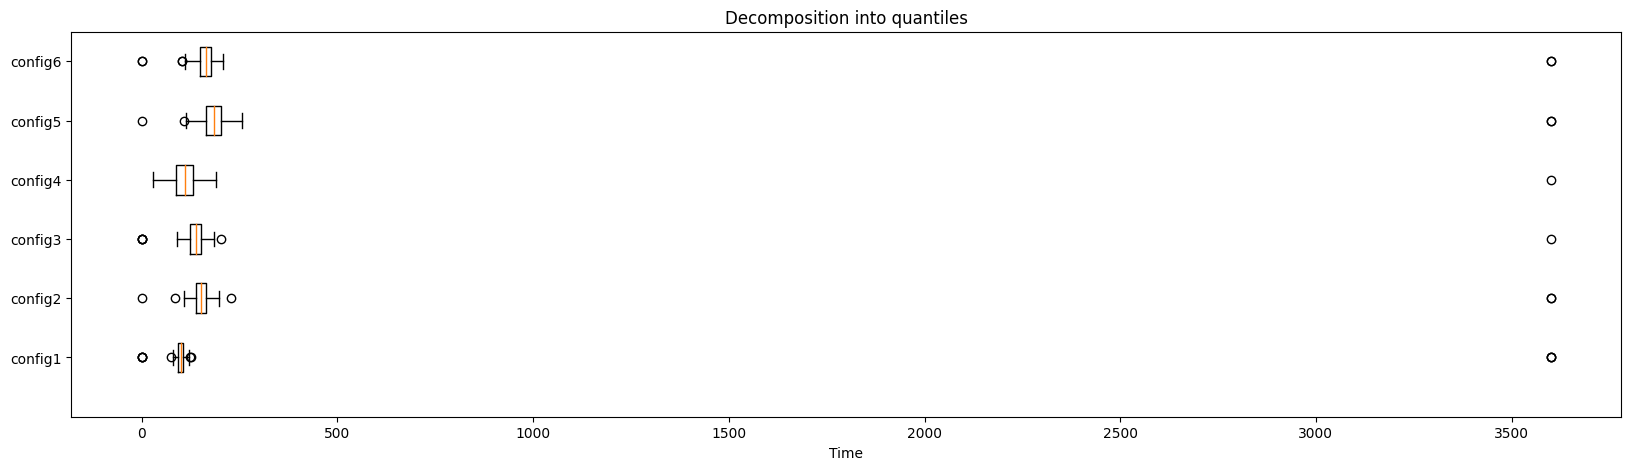

In [3]:
def plotdf(df):
  fig, ax = plt.subplots(figsize=(20,5))
  ax.boxplot([(df.loc[df['conf'] == 'config1', 'time']), df.loc[df['conf'] == 'config2', 'time'], df.loc[df['conf'] == 'config3', 'time'], df.loc[df['conf'] == 'config4', 'time'], df.loc[df['conf'] == 'config5', 'time'], df.loc[df['conf'] == 'config6', 'time']], vert = 0)
  ax.set_yticks([1, 2, 3, 4, 5, 6])
  ax.set_yticklabels(['config1', 'config2', 'config3', 'config4', 'config5', 'config6'])
  ax.set(xlabel="Time", ylim=(0, None))
  plt.title('Decomposition into quantiles') 
  
plotdf(df)

temp = (df.loc[df['conf'] == 'config1', 'time'])
mean = np.mean(temp) 
sd = np.std(temp) 

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Objevily se a může jít o chybné vstupy do algoritmů, které je způsobují, nebo neočekávané krajní hodnoty. Případně další mimořádné podmínky běhu, kdy jiný program souběžně běžící ovlivňuje testovaný algoritmus. Jedna ze situací, které by mohly nastat je, že jiný program vyruší běh s vyšší prioritou a potlačí jeho výpočet do pozadí a čas výpočtu se protáhne, další možnost je že dojde k přerušení a jiný program s vyšší prioritou může měření běhu algoritmu zastavit.
  
Konkrétně některé outliers zde mají běhy v logu hodnotu 'TIME LIMIT' pro Time of run: 3600 a 'SEGFAULT' Time of run: 0.1

Z výše vykresleného grafu jsou vidět ale i další možné outliers, které sice skončili statusem "SUCCESS", ale dopředu nelze odhadnout jestli se doopravdy jedná o správné hodnoty a nebo to jsou outliers maskované jako dobré pod statusem "SUCCESS" (toto může ovlivnit i chyba v algoritmu). Proto když jsou aplikována stejné kritéria na všechny konfigurace a smažu i tyto krajní hodnoty pomocí výpočtu kvantilů, tak výsledek bude správný, protože budu dále porovnávat konfigurace mezi sebou, které byly stejným stylem upravené. 

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

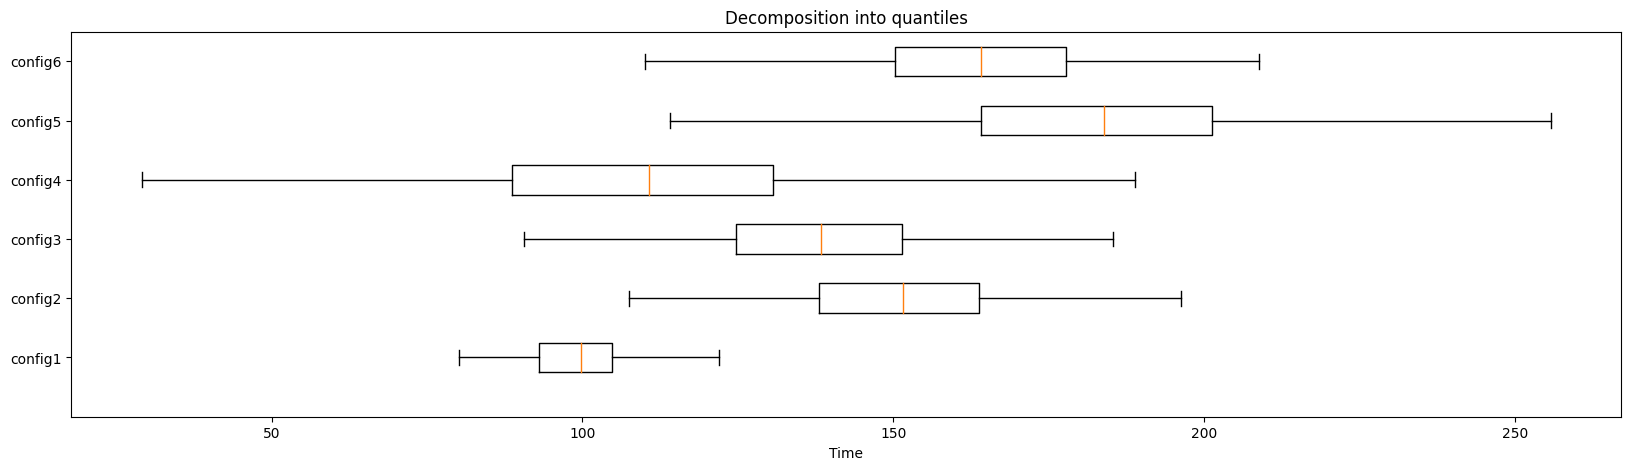

In [4]:
new_df = pd.DataFrame()
temp_df = df
for i in range (1,7):
  Q1 = (temp_df.loc[df['conf'] == 'config' + str(i), 'time']).quantile(0.25)
  Q3 = (temp_df.loc[df['conf'] == 'config' + str(i), 'time']).quantile(0.75)
  IQR = Q3 - Q1
  minimum = Q1 - 1.5*IQR
  maximum = Q3 + 1.5*IQR
  
  a = pd.DataFrame(df.loc[df['conf'] == 'config' + str(i), ['conf', 'time']])
  a.drop(a[a['time'] > maximum].index, inplace = True)
  a.drop(a[a['time'] < minimum].index, inplace = True)
  new_df = pd.concat([new_df, a])
  
df = new_df
plotdf(df)


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
params_disc = {
  "conf": None,
  "mean": np.nan,
  "gmean": np.nan, #geometric mean
  "median": np.nan,
  "quantile":  np.nan,
  "percentile":  np.nan,
  "std":  np.nan, #standart deviation
  "var":  np.nan, #variance
  "skew":  np.nan, #skewness
  "kurtosis":  np.nan,
  "moment":  np.nan,
  "wmean": np.nan, #waighted mean
  "min": np.nan, #waighted mean
  "max": np.nan #waighted mean
}

dp = pd.DataFrame() #descriptive_params
for i in range(1,7):
  config_data = df.loc[df['conf'] == 'config' + str(i), 'time']
  results = {'conf': "config"+str(i),'mean': np.mean(config_data), 'gmean': stats.gmean(config_data), 'median': np.median(config_data), 'quantile': np.quantile(config_data, 0.1), 'percentile': np.percentile(config_data, 0.1), 'std': np.std(config_data), 'var': np.var(config_data), 'skew': stats.skew(config_data), 'kurtosis': stats.kurtosis(config_data), 'moment': stats.moment(config_data, moment=3), 'wmean': np.average(config_data, weights=config_data), 'min': min(config_data), 'max': max(config_data)}
  params_disc.update(results)
  dp = pd.concat([dp, pd.DataFrame(params_disc, index=[0])])
  dp = dp.reset_index(drop=True)
  
dp.index = np.arange(1, 7)
dp

,conf,mean,gmean,median,quantile,percentile,std,var,skew,kurtosis,moment,wmean,min,max
1,config1,99.449016,99.054153,99.799944,87.685270,80.177040,8.843423,78.206139,0.068244,-0.400130,47.198185,100.235411,80.124311,121.904556
2,config2,151.688034,150.547497,151.516091,129.659209,107.905248,18.535340,343.558816,0.112919,-0.328904,719.063229,153.952938,107.522086,196.293171
3,config3,138.292420,136.914802,138.448002,112.360195,91.222242,19.343634,374.176164,0.037482,-0.363419,271.290609,140.998108,90.567110,185.413857
4,config4,110.317016,105.625547,110.782732,70.906043,29.366147,30.579691,935.117531,0.048833,-0.157505,1396.419928,118.793655,29.093401,188.971462
5,config5,184.049441,181.868950,183.916111,149.619396,114.954687,28.204429,795.489812,0.165393,-0.340557,3710.819795,188.371594,114.035821,255.807973
6,config6,163.450775,162.228247,164.185319,137.093135,111.347506,19.766126,390.699725,-0.075834,-0.335620,-585.639310,165.841096,110.011886,208.795048


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._   
  
_mean_: průměr - slouží k spočítání průměrné hodnoty vstupního pole      
_geometric mean:_ geometrický průměr - se používá pro výpočet průměru zřetězených růstových charakteristik v čase    
_median:_ střední hodnota - jaké data jsou obsaženy nejvíckrát    
_quantile:_ kvantil - hodnota, kterou stanovená část p hodnot nepřesahuje, dohromady kvantily tvoří celek, protože rozdělují data na jednotlivé části  
_percentile:_ percentil - pomocí kvantilů rozděluje statistický soubor na setiny a udává odhad pravděpodobnosti, že hodnota je v daném kvantilu  
_standart deviation:_ směrodatná odchylka - určitě nakolik se od sebe navzájem liší jednotlivé případy v souboru zkoumaných hodnot     
_variance:_ rozptyl - určuje variabilitu rozdělení souboru náhodných hodnot kolem její střední hodnoty     
_skewness:_ koeficient šikmosti - určuje nesymetrii. Jsou tři druhy: nulová šikmost (rovnoměrně rozdělené hodnoty vlevo a vpravo od průměru), kladná šikmost (vpravo od průměru jsou hodnoty odlehlejší než vlevo), záporná šikmost (vlevo od průměru jsou hodnoty odlehlejší než vpravo)    
_kurtosis:_  koeficient špičatosti - porovnává dané rozdělení s normálním rozdělením pravděpodobnosti  
_moment:_ moment - je kvantitativní měření tvaru setu hodnot, používá se k výpočtu koeficientu šikmosti a špičatosti (moment=3 je pro koeficient šikmosti)  
_waighted mean:_ vážený průměr - se počítá jako arimetrický průměr, ale k tomu je každé hodnotě v datovém souboru přiřazena váha nebo význam   
_min:_ minimální hodnota    
_max:_ maximální hodnota    

  
Celkově tabulka udává data o konfiguracích, kde na první pohled je možné vyčíst rozdíly pomocí průměrů hodnot. Tím že se přibližně rovná medián i průměr je vidět že konfigurace číslo 5 je na tom pravděpodobně časově nejhůř. Podle mediánu je možné dopředu vyčíst rozložení dat v grafu a podle variance jak budou grafy roztáhnuté pro graf hustoty jednotlivých konfigurací.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

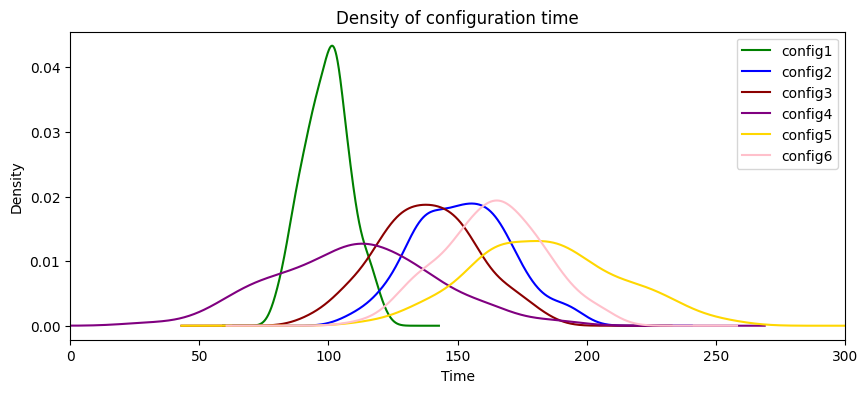

In [6]:
colors = ['green', 'blue', 'darkred', 'purple', 'gold', 'pink']
for i in range(1,7):
  a = df.loc[df['conf'] == 'config' + str(i), 'time']
  a.plot.density(color=colors[i-1], figsize=(10, 4), xlim=(0, 300))
  
plt.xlabel("Time")
plt.title('Density of configuration time') 
plt.legend(['config1', 'config2', 'config3', 'config4', 'config5', 'config6'])
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._
Z grafu lze vidět že konfigurace 1 a 4 má pro hustotu nejmenší hodnoty. Ostatní konfigurace nabývají větších hodnot. Tyto informace lze porovnat s výsledky z tabulky, které vypovídají stejné informace. Konfigurace 5 má největší rozsah hustotu s nejvyššími hodnotami - její běhy budou pravděpodobně nejhorší ze všech běhů.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Budu zkoumat data z konfigurace číslo 1 a 4, protože podle grafu hustoty mají tyto dvě konfigurace největší šanci být zvoleny jako nejlepší, protože body jejich vrcholů jsou nejmenší čísla. Dále jsem vycházela z údajů v tabulce, kde je pro ně nejmenší průměr. Conf 1 má hodnotu variance velmi nízkou oproti conf 4, to zle vidět i z grafu po vyčištění dat ze sekce analýza a čištění dat.    
  
K zvolení správného testu je třeba určit vlastnosti těchto dvou datasetů. Nemají stejnou směrodatnou odchylku, varianci, ani průměr, jsou nezávislé, mají různý počet vzorků. Použila jsem Welch's t-test, který, narozdíl od Student’s t-testu a ostatních, splňuje podmínky datasetu. Jako knihovní funkci jsem použila scipy.stats.mstats.ttest_ind().

Nulová hypotéza H_0: Mezi testovanými daty je nulový rozdíl.

Konfigurace 4 má data omnoho více rozložená, proto má i největší rozptyl ze všech konfigurací, za to konfigurace 1 má nejmenší rozptyl, to vede k tomu že její graf roste do výšky. Jejich parametry lze vyčíst z horní tabulky a rozložení z předchozího grafu společně s grafem ze sekce Analýza a čištění dat. Tam je možné si ověřit rozložení a polohu hodnot s daty z tabulky. Polohu konfigurací hodnot lze vyčíst z tabulky i grafu pomocí průměrů a mediánu, které ukazují že tyto hodnoty jsou nejmenší pro konfigurace 1 a 4 a v grafu jsou jejich grafy posunuty nejvíc vlevo na časové ose běhu algoritmu.

In [7]:
alpha = 0.05 #hranice pro odmitnuti nulove hypotezy, pouziva se nejcasteji tato hodnota
config1 = df.loc[df['conf'] == 'config1', 'time']
config4 = df.loc[df['conf'] == 'config4', 'time']

def printOutput(p_value, statistic):
  print("The null hypothesis H_0: true difference between these configurations is zero")
  if(p_value < alpha):
    print("We reject H_0 hypothesis")
    if(statistic > 0): #
      print(output + "config1")
    else:
      print(output + "config4")
  else:
    print("We do not reject H_0 hypothesis")
  print("\n")
  print("p-value: " + str(p_value))
  print("statistic: " + str(statistic))

output = "Faster configuration is: "
statistic, p_value = stats.mstats.ttest_ind(config4, config1, equal_var=False, alternative='two-sided') #two-sided protoze chci porovnat konfigurace z obou stran
#testuji jestli je prumerna hodnota config4 mensi nez config1. Pokud ano, tak statistic bude zaporna, v opacnem pripade bude config lepsi

printOutput(p_value, statistic)

The null hypothesis H_0: true difference between these configurations is zero
We reject H_0 hypothesis
Faster configuration is: config1


p-value: 2.9027917194699988e-06
statistic: 4.795253225745878


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_  
  
Výsledkem testu je, že config1 je lepší než config4 se spolehlivostí 95%. A vzhledem k tomu, že config1 a config4 jsou lepší než všechny ostatní konfigurace, tak config1 je nejlepší konfigurace ze všech.

In [8]:
def welchs_ttest(array1, array2):
  X_1 = np.mean(array1)
  X_2 = np.mean(array2)
  S2_1 = np.var(array1, ddof=1)
  S2_2 = np.var(array2, ddof=1)
  N_1 = len(array1)
  N_2 = len(array2)

  #vyber vzorcu je z wikipedie podle toho jak se pocita Welch's t-test
  statistic = (X_1 - X_2) / (np.sqrt((S2_1/N_1) + (S2_2/N_2)))
  degrees_of_freedom = (S2_1 / N_1 + S2_2 / N_2)**2 / (((S2_1 / N_1)**2 / (N_1 - 1)) + ((S2_2 / N_2)**2 / (N_2 - 1)))
  
  p_value = 2* (1- stats.t.cdf(statistic, df=degrees_of_freedom)) #2* protoze two-sided
  return statistic, p_value

statistic, p_value = welchs_ttest(config4, config1)
printOutput(p_value, statistic)


The null hypothesis H_0: true difference between these configurations is zero
We reject H_0 hypothesis
Faster configuration is: config1


p-value: 2.9027917194390795e-06
statistic: 4.795253225745878
